# Solutions for Assignment 5: Web Scraping and Big Data

**NOTE: THIS ASSIGNMENT IS OPTIONAL**

You must complete one out of homeworks #4, #5, and #6.

**Due date: Wednesday, 11/10 by the end of the day**

The notebook should be submitted to your own private repository on GitHub, which can be created using the following link:

https://classroom.github.com/a/qAl3_6Ze

### Part 1: Scraping Craigslist

In this section, you will use BeautifulSoup to scraping data for hundreds of apartments from Philadelphia's Craigslist portal.

### Part 2: Exploring a "large" dataset of your choice

In this section, you'll use datashader to create an animated timelapse of a "large" dataset of your choice.

In [1]:
# start with some packages we'll need
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Part 1: Scraping Craigslist

In this part, we'll be extracting information on apartments from Craigslist search results. You'll be using BeautifulSoup to extract the relevant information from the HTML text. 

For reference on CSS selectors, please see the [notes from Week 6](https://github.com/MUSA-550-Fall-2021/week-6/blob/main/css-selectors.md).

### Getting the HTML

We'll start with the Philadelphia region


First we need to figure out how to submit a query to Craigslist. As with many websites, one way you can do this is simply by constructing the proper URL and sending it to Craigslist. Here's a sample URL that is returned after manually typing in a search to Craigslist:

 http://philadelphia.craigslist.org/search/apa?bedrooms=1&pets_cat=1&pets_dog=1&is_furnished=1

There are two components to this URL. 

1. The base URL: `http://philadelphia.craigslist.org/search/apa`
1. The user's search parameters: `?bedrooms=1&pets_cat=1&pets_dog=1&is_furnished=1`

We will use `requests.get()` function to get the search page's response. For the search parameters, we will set `bedrooms=1`, which will make sure the number of bedrooms is listed. 

This can be done easiest by using the `params` keyword of the `get()` function.

In [2]:
import requests

In [3]:
url_base = 'http://philadelphia.craigslist.org/search/apa'
params = {'bedrooms': 1}
rsp = requests.get(url_base, params=params)

In [4]:
# Note that requests automatically created the right URL:
print(rsp.url)

https://philadelphia.craigslist.org/search/apa?bedrooms=1


## 1.1 Parsing the HTML

- Use BeautifulSoup to parse the HTML response.
- Use the Web Inspector to identify the HTML element that holds the information on each apartment listing.
- Use BeautifulSoup to extract these elements from the HTML. You should have a list of 120 elements, where each element is the listing for a specific apartment on the search page.

In [5]:
from bs4 import BeautifulSoup as bs4

In [6]:
html = bs4(rsp.text, 'html.parser')

In [7]:
html.select("li div")[0]

<div class="favorites">
<a class="favlink" href="#"><span aria-hidden="true" class="icon icon-star fav"></span><span class="fav-number">0</span><span class="fav-label"> favorites</span></a>
</div>

In [8]:
apts = html.select('.result-row')
print(len(apts))

120


## 1.2 Find the relevant pieces of information

We will now focus on the first element in the list of 120 apartments. Use the `prettify()` function to print out the HTML for this first element. 

From this HTML, identify the HTML elements that hold:

- The apartment price
- The number of bedrooms and square footage (this will be in a single element)
- The apartment title
- The datetime string of the posting, e.g., '2019-03-23 12:07'

For the first apartment, print out each of these pieces of information, using BeautifulSoup to select the proper elements.

**Hints**
- Each of these can be extracted using the `text` attribute of the selected element object, except for the datetime string. This information is stored as an *attribute* of an HTML element and is not part of the displayed text on the webpage

In [9]:
this_appt = apts[0]
print(this_appt.prettify())

<li class="result-row" data-pid="7414214010" data-repost-of="7127342946">
 <a class="result-image gallery empty" href="https://philadelphia.craigslist.org/apa/d/drexel-hill-perfect-old-fashioned-and/7414214010.html">
 </a>
 <div class="result-info">
  <span class="icon icon-star" role="button">
   <span class="screen-reader-text">
    favorite this post
   </span>
  </span>
  <time class="result-date" datetime="2021-11-29 17:17" title="Mon 29 Nov 05:17:17 PM">
   Nov 29
  </time>
  <h3 class="result-heading">
   <a class="result-title hdrlnk" data-id="7414214010" href="https://philadelphia.craigslist.org/apa/d/drexel-hill-perfect-old-fashioned-and/7414214010.html" id="postid_7414214010">
    Perfect old Fashioned and Modern, Drexel Hill!
   </a>
  </h3>
  <span class="result-meta">
   <span class="result-price">
    $1,100
   </span>
   <span class="housing">
    3br -
   </span>
   <span class="result-hood">
    (Drexel Hill  )
   </span>
   <span class="result-tags">
   </span>
   <s

In [10]:
apt_price = this_appt.select_one(".result-price").text
print(apt_price)

$1,100


In [11]:
housing = this_appt.select_one(".housing").text
print(housing)


                    3br -
                


In [12]:
datetime = this_appt.select_one(".result-date")['datetime']
print(datetime)

2021-11-29 17:17


In [13]:
title = this_appt.select_one(".result-title").text
print(title)

Perfect old Fashioned and Modern, Drexel Hill!


## 1.3 Functions to format the results 

In this section, you'll create two functions that take the price and time results from the last section and format them properly.

I've provided a function that will format the size and bedrooms string properly (no additional work needed), and started two functions to format the price and time. You should finish theses functions in this section.

In [14]:
import re

In [15]:
def format_size_and_bedrooms(size_string):
    """
    Extract size and number of bedrooms from the raw
    text, using regular expressions
    """
    split = re.findall("\n(.*?) -", size_string)

    # both size and bedrooms are listed
    if len(split) == 2:
        n_brs = split[0].strip().replace("br", "")
        this_size = split[1].strip().replace("ft2", "")
    # only bedrooms is listed
    elif "br" in split[0]:
        n_brs = split[0].strip().replace("br", "")
        this_size = np.nan
    # only size is listed
    elif "ft2" in split[0]:
        # It's the size
        this_size = split[0].strip().replace("ft2", "")
        n_brs = np.nan

    # return floats
    return float(this_size), float(n_brs)

In [16]:
def format_price(price_string):
    # Format the price string and return a float
    # 
    # This will involve using the string.strip() function to 
    # remove unwanted characters
    return float(price_string.strip("$").replace(",", ""))

In [17]:
def format_time(date_string):
    # Return a Datetime object from the datetime string
    return  pd.to_datetime(date_string)

## 1.4: Putting it all together

In this part, you'll complete the code block below using results from previous parts. The code will loop over 5 pages of search results and scrape data for 600 apartments.

In the code below, the outer for loop will loop over 5 pages of search results. The inner for loop will loop over the 120 apartments listed on each search page.

After filling in the missing pieces and executing the code cell, you should have a Data Frame called `results` that holds the data for 600 apartment listings.

#### Notes

Be careful if you try to scrape more listings. Craigslist will temporarily ban your IP address (for a very short time) if you scrape too much at once. I've added a `sleep()` function to the for loop to wait 30 seconds between scraping requests.

If the for loop gets stuck at the "Processing page X..." step for more than a minute or so, your IP address is probably banned temporarily, and you'll have to wait a few minutes before trying again.

In [18]:
from time import sleep

In [19]:
results = []

# search in batches of 120 for 5 pages
# NOTE: you will get temporarily banned if running more than ~5 pages or so
# the API limits are more leninient during off-peak times, and you can try
# experimenting with more pages
max_pages = 5
results_per_page = 120
search_indices = np.arange(0, max_pages*results_per_page, results_per_page) 
url = 'http://philadelphia.craigslist.org/search/apa'

# loop over each page of search results
for i, s in enumerate(search_indices):
    print('Processing page %s...' % (i+1) )
    
    # get the response
    resp = requests.get(url, params={'bedrooms': 1, 's': s})
    
    # YOUR CODE: get the list of all aparements
    # This is the same code from Part 1.1
    # It should be a list of 120 apartments
    html = bs4(resp.text, 'html.parser')
    apts = html.select('.result-row')
    print("number of apartments = ", len(apts))

    # loop over each apartment in the list
    page_results = []
    for apt in apts:
        
        # YOUR CODE: the bedrooms/size string
        sizes_brs = apt.select_one('.housing').text

        # YOUR CODE: the title string
        title = apt.select_one('.result-title').text

        # YOUR CODE: the price string
        price = apt.select_one('.result-price').text

        # YOUR CODE: the time string
        dtime = apt.select_one('.result-date')['datetime']
        
        # format using functions from Part 1.3
        sizes, brs = format_size_and_bedrooms(sizes_brs)
        price = format_price(price)
        dtime = format_time(dtime)
        
        # save the result
        page_results.append([dtime, price, sizes, brs, title])
        
    # create a dataframe and save
    col_names = ['time', 'price', 'size', 'brs', 'title']
    df = pd.DataFrame(page_results, columns=col_names)
    results.append(df)
    
    print("sleeping for 30 seconds between calls")
    sleep(30)
    
# Finally, concatenate all the results
results = pd.concat(results, axis=0).reset_index(drop=True)

Processing page 1...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 2...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 3...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 4...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 5...
number of apartments =  120
sleeping for 30 seconds between calls


In [20]:
results.head()

,time,price,size,brs,title
0,2021-11-29 17:17:00,1100.0,NaN,3.0,"Perfect old Fashioned and Modern, Drexel Hill!"
1,2021-11-29 17:15:00,825.0,NaN,1.0,Spacious rooms! All modern kitchen!
2,2021-11-29 17:15:00,900.0,NaN,1.0,"Mansion apartment, High ceilings!"
3,2021-11-29 17:09:00,800.0,1200.0,2.0,lager living room 1st floor---COOL down at Par...
4,2021-11-29 17:06:00,1750.0,1000.0,2.0,Renovated Two Bedroom in East Passyunk


In [21]:
results = results.dropna(subset=['price', 'size'])

## 1.5 Plotting the distribution of prices

Use matplotlib's `hist()` function to make two histograms for:

- Apartment prices
- Apartment prices per square foot (price / size)

Make sure to add labels to the respective axes and a title describing the plot.

### Side note: rental prices per sq. ft. from Craigslist

The histogram of price per sq ft should be centered around ~1.5. Here is a plot of how Philadelphia's rents compare to the other most populous cities:

<img src="imgs/rental_prices_psf.png" width=600/>

[Source](https://arxiv.org/pdf/1605.05397.pdf)

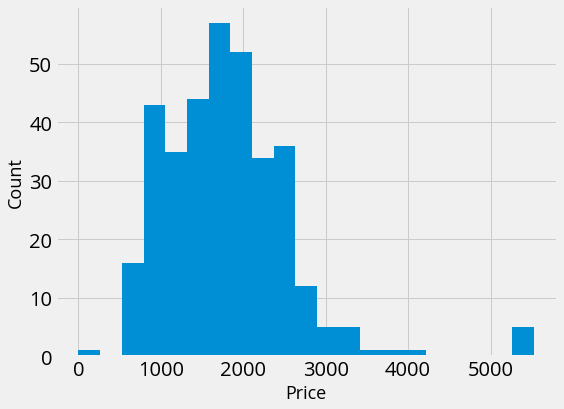

In [22]:
with plt.style.context('fivethirtyeight'):
    
    # initialize the figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # plot the histogram, using automatic bins
    ax.hist(results['price'], bins='auto')

    # label the axes
    ax.set_xlabel('Price', fontsize=18)
    ax.set_ylabel('Count', fontsize=18)

In [23]:
# calculate price per square foot
results['price_psf'] = results['price'] / results['size']

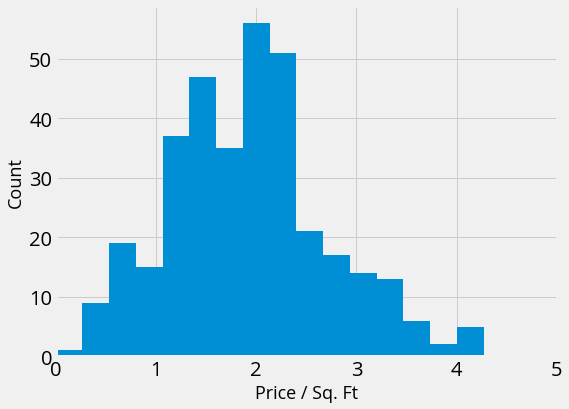

In [24]:
with plt.style.context('fivethirtyeight'):
    
    # initialize the figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # plot price per square foot
    ax.hist(results.loc[results['size'] > 0, 'price_psf'], bins='auto')

    # Format the axes
    ax.set_xlabel('Price / Sq. Ft', fontsize=18)
    ax.set_ylabel('Count', fontsize=18)
    ax.set_xlim(0, 5)

## 1.6 Comparing prices for different sizes 

Use `altair` to explore the relationship between price, size, and number of bedrooms. Make an interactive scatter plot of price (x-axis) vs. size (y-axis), with the points colored by the number of bedrooms. 

Make sure the plot is interactive (zoom-able and pan-able) and add a tooltip with all of the columns in our scraped data frame.

With this sort of plot, you can quickly see the outlier apartments in terms of size and price.

In [25]:
import altair as alt

In [26]:
len(results)

348

In [27]:
alt.Chart(results).mark_point(size=60).encode(
    x=alt.X("price:Q"),
    y=alt.Y("size:Q"),
    color="brs:N",
    tooltip=["title", "price", "size", "brs"],
).interactive()

alt.Chart(...)

## Part 2: Making an animated map with Datashader

In this part, you will load a "large" data set of your choice and make an animated map of the data using datashader. 

There are several good options available from Open Data Philly, but you are welcome to choose a different source, as long it meets the requirements below.

#### Deliverable
Your final result should be a GIF animating changes in the data set in time. This GIF should be submitted to your repository, and the code used to produce the GIF should be in the notebook.

#### Notes
- For best results with datashader, the dataset should be at least 500,000 rows in size. If you are having difficulty finding a data set large enough, please email me.
- The data must have a date time column, so that you can animate the data in time.
- You can use either dask or pandas to load the data. If you're data set is approaching the size of your machine's memory, you will want to use dask.
- Recommendations from Open Data Philly include: 
    - [311 Requests](https://www.opendataphilly.org/dataset/311-service-and-information-requests)
    - [Crime Incidents](https://www.opendataphilly.org/dataset/crime-incidents)
    - [L&I Code Violations](https://www.opendataphilly.org/dataset/licenses-and-inspections-violations)
    - [Real Estate Transfers](https://www.opendataphilly.org/dataset/real-estate-transfers)
- You can animate the data by the hour or by the year, e.g., parking violations by hour of day, or parking violations by year.

#### Examples
I've includes several potential examples in the assignment repository.

#### Optional
You can overlay Philadelphia city limits using geopandas. See the lecture slides for an example of how to do this.

In [28]:
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import viridis
from datashader.utils import lnglat_to_meters as webm
import geopandas as gpd

In [29]:
# load the city limits
city_limits = gpd.read_file("data/City_Limits.geojson").to_crs(epsg=3857)

In [31]:
# Load Criminal Incident data 
# Downloaded from OpenDataPhilly
df = pd.read_csv("data/incidents_part1_part2.csv")

# convert to web mercator x and y
df['x'], df['y'] = webm(df['lng'], df['lat'])

# add an hour column
df['dispatch_date_time'] = pd.to_datetime(df['dispatch_date_time'])
df['hour'] = df['dispatch_date_time'].dt.hour

In [32]:
def create_image(df, x_range, y_range, w=750, h=750, cmap=viridis):
    
    # create the canvas
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    
    # plot dropoff positions, coutning number of passengers
    agg = cvs.points(df, 'x', 'y')
    
    # shade
    img = tf.shade(agg, cmap=cmap, how='eq_hist', min_alpha=150)
    
    # return an PIL image
    return tf.set_background(img, "black").to_pil()

In [33]:
def convert_to_12hour(hr24):
    """
    Convert from 24 hr to 12 hr.
    """
    from datetime import datetime

    d = datetime.strptime(str(hr24), "%H")
    return d.strftime("%I %p")

In [34]:
def plot_by_hour(fig, df_all_hours, hour, title):
    """
    Plot for a particular hour
    """
    # get the x and y range from the city limits
    # extent = [xmin, ymin, xmax, ymax]
    extent = city_limits.total_bounds
    x_range = extent[0], extent[2]
    y_range = extent[1], extent[3]

    # data for this hour
    df = df_all_hours.loc[df_all_hours['hour']==hour]

    # create the image for this hour
    img = create_image(df, x_range, y_range)

    # plot the image on a matplotlib axes
    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
    ax.axis("off")

    # add city limits
    city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=2)

    # add a text label for the hour
    t = convert_to_12hour(hour)
    ax.text(0.05, 0.9, t, color="white", fontsize=40, ha="left", transform=ax.transAxes)

    # add the title
    fig.text(0.72, 0.2, title, fontsize=35, color="white", ha="center")

    # format the axes
    ax.set_axis_off()
    ax.set_aspect("equal")
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.tight_layout()

    # draw the figure and return the image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

In [35]:
import imageio

In [36]:
title = "Philadelphia\nCriminal Incidents\nSince 2006"
filename = 'crime_incidents.gif'

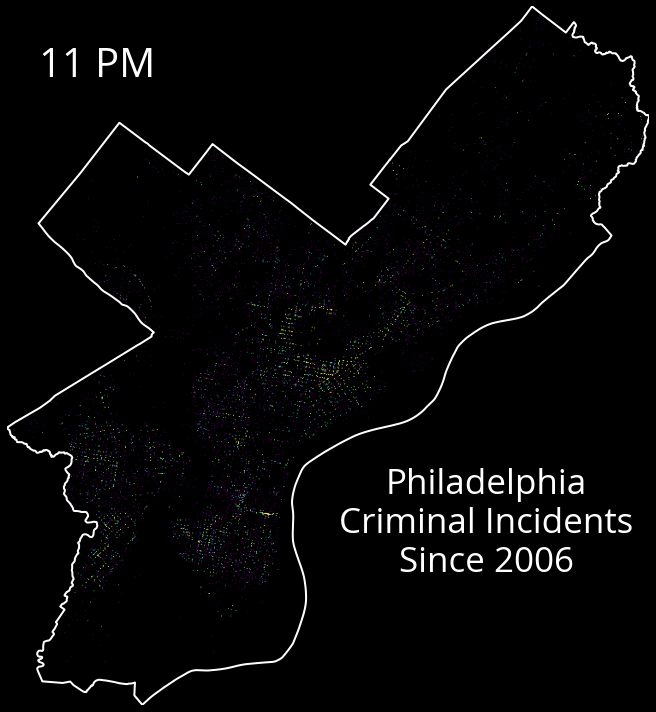

In [37]:
# create a figure
fig, ax = plt.subplots(figsize=(10,10), facecolor='black')

# get the selection
hours = list(range(24))
fps = 1 

# make the images for each hour
images = []
for hour in hours:
    image = plot_by_hour(fig, df, hour, title)
    images.append(image)
    
# combine the images into a GIF
imageio.mimsave(filename, images, fps=fps);